In [1]:
import os, subprocess
import json
import uproot
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pandas as pd
import pickle

#Plot settings
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
#mpl.rcParams['lines.linewidth'] = 5

#Dataset parameters
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('../xsec.json') as f:
    xs = json.load(f)

with open('../pmap.json') as f:
    pmap = json.load(f)

systematics = ['nominal',
               'jet_triggerUp','jet_triggerDown',
               'btagWeightUp','btagWeightDown','btagEffStatUp','btagEffStatDown',
               'UESUp','UESDown','JESUp','JESDown','JERUp','JERDown',
              ]

mc = ['QCD', 'ttbar', 'ttH' ,'singlet', 'Wjets','Zjets','VV','EWKZ','EWKW','ggF','VBF','WH','ZH']


#To calculate significance
def significance(s,b):
    if b==0:
        return 0
    z_squared = 2.0*(s+b)*np.log(1.0+1.0*s/b) - 2.0*s
    return np.sqrt(z_squared)

In [2]:
picklename = "2017_sig_scan/templates.pkl"
templates = pickle.load(open(picklename,'rb'))\
            .integrate('msd1',slice(117.,131.))\
            .integrate('j2pt', slice(200,1200))\
            .integrate('region','signal')

In [3]:
templates.sum(*['ddb1', 'ddc2'])

<Hist (process) instance at 0x7f9482bdb850>

## Cut optimization

In [4]:
def add_significance(s_forward, b_forward, s_backward, b_backward):
    
    forward_sign = significance(s_forward, b_forward)
    backward_sign = significance(s_backward, b_backward)
    
    return np.hypot(forward_sign, backward_sign)

def opt_significance(templates, proc = 'ZH'):

    significance_table = np.zeros((100,100))
    ddb1_thresholds = templates.axis('ddb1').edges()
    ddc2_thresholds = templates.axis('ddc2').edges()
    
    b_list = [x for x in mc if x not in ['ZH', 'WH']] #Background
    
    #Index counter for the main matrix
    i = 0
    for ddb_thres in ddb1_thresholds[:-1]: #ddb1
        
        j = 0
        for ddc_thres in ddc2_thresholds[:-1]: #ddc2
            try:
                # ≥ cuts
                s_forward = templates.integrate('process', proc)\
                             .integrate('ddb1', int_range = slice(ddb_thres,1.))\
                             .integrate('ddc2', int_range = slice(ddc_thres,1.))\
                             .values()[()]

                b_forward = templates.integrate('process', b_list)\
                             .integrate('ddb1', int_range = slice(ddb_thres,1.))\
                             .integrate('ddc2', int_range = slice(ddc_thres,1.))\
                             .values()[()]
                # < cuts
                s_backward = templates.integrate('process', proc)\
                             .integrate('ddb1', int_range = slice(ddb_thres, 1.))\
                             .integrate('ddc2', int_range = slice(0., ddc_thres))\
                             .values()[()]

                b_backward = templates.integrate('process', b_list)\
                             .integrate('ddb1', int_range = slice(ddb_thres,1.))\
                             .integrate('ddc2', int_range = slice(0., ddc_thres))\
                             .values()[()]

                significance_table[i][j] = add_significance(s_forward, b_forward, s_backward, b_backward)
            except:
                print("Triggering faults!! (i,j) = ", (i,j))
                significance_table[i][j] = 0
            
            #ddc index counter
            j += 1
            
        #ddb index counter
        i += 1
        
    return significance_table

In [5]:
scan_vh = opt_significance(templates, proc = ['ZH','WH'])

Triggering faults!! (i,j) =  (34, 0)
Triggering faults!! (i,j) =  (34, 1)
Triggering faults!! (i,j) =  (34, 2)
Triggering faults!! (i,j) =  (34, 3)
Triggering faults!! (i,j) =  (34, 4)
Triggering faults!! (i,j) =  (34, 5)
Triggering faults!! (i,j) =  (34, 6)
Triggering faults!! (i,j) =  (34, 7)
Triggering faults!! (i,j) =  (34, 8)
Triggering faults!! (i,j) =  (34, 9)
Triggering faults!! (i,j) =  (34, 10)
Triggering faults!! (i,j) =  (34, 11)
Triggering faults!! (i,j) =  (34, 12)
Triggering faults!! (i,j) =  (34, 13)
Triggering faults!! (i,j) =  (34, 14)
Triggering faults!! (i,j) =  (34, 15)
Triggering faults!! (i,j) =  (34, 16)
Triggering faults!! (i,j) =  (34, 17)
Triggering faults!! (i,j) =  (34, 18)
Triggering faults!! (i,j) =  (34, 19)
Triggering faults!! (i,j) =  (34, 20)
Triggering faults!! (i,j) =  (34, 21)
Triggering faults!! (i,j) =  (34, 22)
Triggering faults!! (i,j) =  (34, 23)
Triggering faults!! (i,j) =  (34, 24)
Triggering faults!! (i,j) =  (34, 25)
Triggering faults!! (i

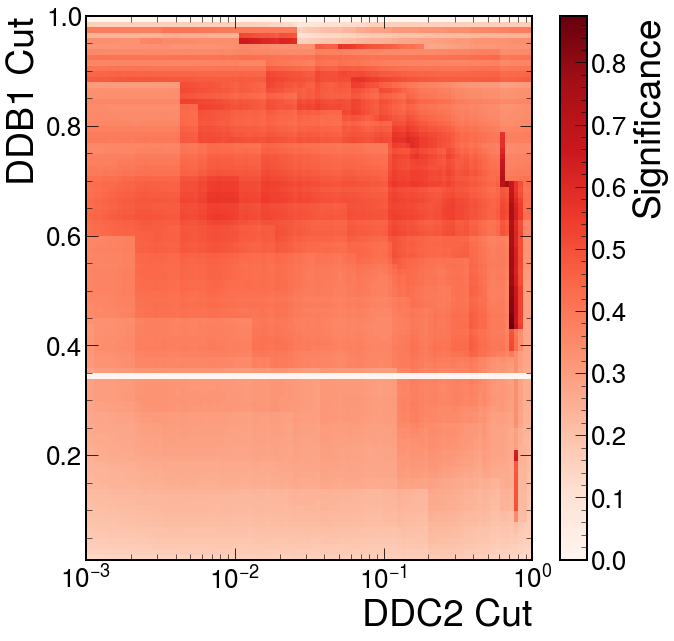

In [6]:
x = templates.axis('ddc2').edges()[1:]
y = templates.axis('ddb1').edges()[1:]

fig, ax = plt.subplots()

ax.set_xscale("log")
pos = ax.pcolor(x,y, scan_vh[1:,1:],cmap = 'Reds')
ax.autoscale('tight')

cbar = plt.colorbar(pos,ax = ax)
cbar.set_label('Significance')

plt.ylabel('DDB1 Cut')
plt.xlabel('DDC2 Cut')

plt.show()

In [30]:
def print_significance(templates, scan):

    ddb1_thresholds = templates.axis('ddb1').edges()[:-1]
    ddc2_thresholds = templates.axis('ddc2').edges()[:-1]
    
    thres_list = []
    thres_list_2 = []
    thres_sign = []
    
    for i in range(len(ddb1_thresholds)):
        for j in range(len(ddc2_thresholds)):
            if scan[i,j] >= 0.6:
                print("DDB: {}; DDC: {}".format(ddb1_thresholds[i],ddc2_thresholds[j]))
                print("SIGNIFICANCE: ", scan[i,j])
                print("=============")
                
                thres_list.append('"{} {}"'.format(ddb1_thresholds[i],ddc2_thresholds[j]))
                thres_list_2.append([ddb1_thresholds[i],ddc2_thresholds[j]])
                thres_sign.append(scan[i,j])
    
    print("THRESHOLD LIST: ", *thres_list)
    print("THERE ARE {} PAIRS".format(len(thres_list)))
    
    print(thres_list_2)
    print(thres_sign)
    
    

#     for i in range(70,80):
#         for j in range(75,85):
#             print("DDB: {}; DDC: {}".format(ddb1_thresholds[i],ddc2_thresholds[j]))
#             print("SIGNIFICANCE: ", scan[i,j])
#             print("=============")
            
print_significance(templates, scan_vh)

DDB: 0.19; DDC: 0.7564633275546291
SIGNIFICANCE:  0.6458271795640514
DDB: 0.2; DDC: 0.7564633275546291
SIGNIFICANCE:  0.6377282754456779
DDB: 0.43; DDC: 0.7054802310718645
SIGNIFICANCE:  0.8746361277020256
DDB: 0.43; DDC: 0.7564633275546291
SIGNIFICANCE:  0.6996458733824784
DDB: 0.44; DDC: 0.7054802310718645
SIGNIFICANCE:  0.8505089468473247
DDB: 0.44; DDC: 0.7564633275546291
SIGNIFICANCE:  0.6723712308817534
DDB: 0.45; DDC: 0.7054802310718645
SIGNIFICANCE:  0.8398532474012949
DDB: 0.45; DDC: 0.7564633275546291
SIGNIFICANCE:  0.6755382153394359
DDB: 0.46; DDC: 0.7054802310718645
SIGNIFICANCE:  0.8172384857473686
DDB: 0.46; DDC: 0.7564633275546291
SIGNIFICANCE:  0.6744084164758224
DDB: 0.47000000000000003; DDC: 0.7054802310718645
SIGNIFICANCE:  0.8158768064604572
DDB: 0.47000000000000003; DDC: 0.7564633275546291
SIGNIFICANCE:  0.6728877288829913
DDB: 0.48; DDC: 0.7054802310718645
SIGNIFICANCE:  0.8157073662519327
DDB: 0.48; DDC: 0.7564633275546291
SIGNIFICANCE:  0.6726982784945044
DDB: 

In [47]:
def read_sign_from_scan(scan_dir = "../vh_combine/combine_scan"):
    
    thres_list = [[0.19, 0.7564633275546291], [0.2, 0.7564633275546291], [0.43, 0.7054802310718645], [0.43, 0.7564633275546291], [0.44, 0.7054802310718645], [0.44, 0.7564633275546291], [0.45, 0.7054802310718645], [0.45, 0.7564633275546291], [0.46, 0.7054802310718645], [0.46, 0.7564633275546291], [0.47000000000000003, 0.7054802310718645], [0.47000000000000003, 0.7564633275546291], [0.48, 0.7054802310718645], [0.48, 0.7564633275546291], [0.49, 0.7054802310718645], [0.49, 0.7564633275546291], [0.5, 0.7054802310718645], [0.5, 0.7564633275546291], [0.51, 0.7054802310718645], [0.51, 0.7564633275546291], [0.52, 0.7054802310718645], [0.52, 0.7564633275546291], [0.53, 0.7054802310718645], [0.53, 0.7564633275546291], [0.54, 0.7054802310718645], [0.54, 0.7564633275546291], [0.55, 0.7054802310718645], [0.55, 0.7564633275546291], [0.56, 0.7054802310718645], [0.56, 0.7564633275546291], [0.5700000000000001, 0.7054802310718645], [0.5700000000000001, 0.7564633275546291], [0.58, 0.7054802310718645], [0.58, 0.7564633275546291], [0.59, 0.7054802310718645], [0.59, 0.7564633275546291], [0.6, 0.7054802310718645], [0.6, 0.7564633275546291], [0.61, 0.7054802310718645], [0.61, 0.7564633275546291], [0.62, 0.7054802310718645], [0.63, 0.7054802310718645], [0.63, 0.7564633275546291], [0.64, 0.7054802310718645], [0.64, 0.7564633275546291], [0.65, 0.7054802310718645], [0.65, 0.7564633275546291], [0.66, 0.7054802310718645], [0.67, 0.7054802310718645], [0.68, 0.7054802310718645], [0.6900000000000001, 0.6135907273413176], [0.6900000000000001, 0.6579332246575682], [0.6900000000000001, 0.7054802310718645], [0.7000000000000001, 0.6135907273413176], [0.71, 0.6135907273413176], [0.72, 0.6135907273413176], [0.73, 0.6135907273413176], [0.74, 0.6135907273413176], [0.75, 0.6135907273413176], [0.77, 0.14174741629268048], [0.9500000000000001, 0.010722672220103232], [0.9500000000000001, 0.011497569953977356], [0.9500000000000001, 0.012328467394420659], [0.9500000000000001, 0.013219411484660293], [0.9500000000000001, 0.014174741629268055], [0.9500000000000001, 0.01519911082952934], [0.9500000000000001, 0.016297508346206444], [0.9500000000000001, 0.02009233002565047], [0.9500000000000001, 0.021544346900318846], [0.9500000000000001, 0.023101297000831605]]
    thres_sign = [0.6458271795640514, 0.6377282754456779, 0.8746361277020256, 0.6996458733824784, 0.8505089468473247, 0.6723712308817534, 0.8398532474012949, 0.6755382153394359, 0.8172384857473686, 0.6744084164758224, 0.8158768064604572, 0.6728877288829913, 0.8157073662519327, 0.6726982784945044, 0.80136070399212, 0.6566825254266778, 0.8021832583537355, 0.6577210241050866, 0.7807494537923267, 0.6339606959943936, 0.7784513202683319, 0.6320359899500626, 0.7681751515062876, 0.6205079440995366, 0.7701329392069767, 0.6281527905258479, 0.7704850906764871, 0.628629274740768, 0.7670339269088841, 0.6249294560892262, 0.7664490772830053, 0.6243790381347899, 0.7510240350536739, 0.6069301578165708, 0.7506156343204333, 0.6064538448871623, 0.744347359201623, 0.6115697075316335, 0.7372008023878067, 0.603866002983433, 0.7245885908667486, 0.7496081925865788, 0.6285338272153016, 0.7464514482811865, 0.6254918031816128, 0.7418883562452704, 0.6200309623468242, 0.7076366576390752, 0.6815176403016827, 0.6709940689923596, 0.7050694794775899, 0.7552523595876565, 0.6686210445021209, 0.7228484124924166, 0.7008537626999414, 0.6844917076185975, 0.662839694098874, 0.6384127177625254, 0.6124531349018394, 0.6054450951876829, 0.6504308886260545, 0.6460657615272097, 0.6418455235491037, 0.6330577767119137, 0.6254062034109685, 0.6085733407922671, 0.605074738427029, 0.6171413975563745, 0.6140229785691483, 0.6094787010829951]
    
    scan_dir_list = [x for x in next(os.walk(scan_dir))[1] if x.startswith('DDB')]
    
#     print(scan_dir_list)
#     print("TOTAL DIR: ", len(scan_dir_list))
    
    for i in range(len(thres_list)):
        
        thres_pair = thres_list[i]
        
        print("DDB: {}; DDC: {}".format(thres_pair[0],thres_pair[1]))
        print("S/sqrt(B) Significance: ", thres_sign[i])
        
        scan_workspace = "DDB-{}-DDC-{}".format(thres_pair[0],thres_pair[1])
        
        sign_file = os.path.join(scan_dir, scan_workspace, "2017", "sign.out")
        
        with open(sign_file) as f:
            lines = f.readlines()
            lines = [line.rstrip() for line in lines]
            
            print("Combine Significance: ", lines[7][14:])
            #print(lines[7])
        
        print("===========")
            
#TODO: print S and B for each of the blocks
        
read_sign_from_scan()

DDB: 0.19; DDC: 0.7564633275546291
S/sqrt(B) Significance:  0.6458271795640514
Combine Significance:  0.0173744
DDB: 0.2; DDC: 0.7564633275546291
S/sqrt(B) Significance:  0.6377282754456779
Combine Significance:  0.0173744
DDB: 0.43; DDC: 0.7054802310718645
S/sqrt(B) Significance:  0.8746361277020256
Combine Significance:  0.0173744
DDB: 0.43; DDC: 0.7564633275546291
S/sqrt(B) Significance:  0.6996458733824784
Combine Significance:  0.0173744
DDB: 0.44; DDC: 0.7054802310718645
S/sqrt(B) Significance:  0.8505089468473247
Combine Significance:  0.0173744
DDB: 0.44; DDC: 0.7564633275546291
S/sqrt(B) Significance:  0.6723712308817534
Combine Significance:  0.0173744
DDB: 0.45; DDC: 0.7054802310718645
S/sqrt(B) Significance:  0.8398532474012949
Combine Significance:  0.0173744
DDB: 0.45; DDC: 0.7564633275546291
S/sqrt(B) Significance:  0.6755382153394359
Combine Significance:  0.0173744
DDB: 0.46; DDC: 0.7054802310718645
S/sqrt(B) Significance:  0.8172384857473686
Combine Significance:  0.0

-----

In [6]:
scan_zh = opt_significance(templates, proc = ['ZH'])

Triggering faults!! (i,j) =  (34, 0)
Triggering faults!! (i,j) =  (34, 1)
Triggering faults!! (i,j) =  (34, 2)
Triggering faults!! (i,j) =  (34, 3)
Triggering faults!! (i,j) =  (34, 4)
Triggering faults!! (i,j) =  (34, 5)
Triggering faults!! (i,j) =  (34, 6)
Triggering faults!! (i,j) =  (34, 7)
Triggering faults!! (i,j) =  (34, 8)
Triggering faults!! (i,j) =  (34, 9)
Triggering faults!! (i,j) =  (34, 10)
Triggering faults!! (i,j) =  (34, 11)
Triggering faults!! (i,j) =  (34, 12)
Triggering faults!! (i,j) =  (34, 13)
Triggering faults!! (i,j) =  (34, 14)
Triggering faults!! (i,j) =  (34, 15)
Triggering faults!! (i,j) =  (34, 16)
Triggering faults!! (i,j) =  (34, 17)
Triggering faults!! (i,j) =  (34, 18)
Triggering faults!! (i,j) =  (34, 19)
Triggering faults!! (i,j) =  (34, 20)
Triggering faults!! (i,j) =  (34, 21)
Triggering faults!! (i,j) =  (34, 22)
Triggering faults!! (i,j) =  (34, 23)
Triggering faults!! (i,j) =  (34, 24)
Triggering faults!! (i,j) =  (34, 25)
Triggering faults!! (i

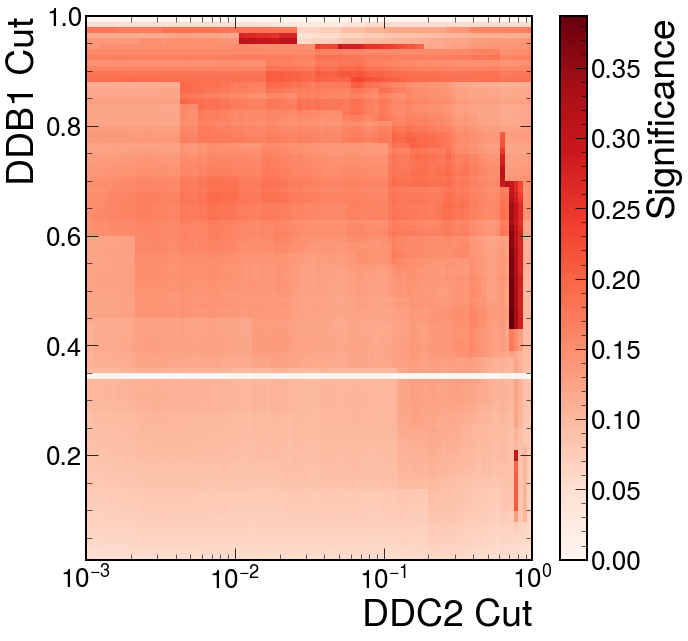

In [7]:
x = templates.axis('ddc2').edges()[1:]
y = templates.axis('ddb1').edges()[1:]

fig, ax = plt.subplots()

ax.set_xscale("log")
pos = ax.pcolor(x,y, scan_zh[1:,1:],cmap = 'Reds')
ax.autoscale('tight')

cbar = plt.colorbar(pos,ax = ax)
cbar.set_label('Significance')

plt.ylabel('DDB1 Cut')
plt.xlabel('DDC2 Cut')

plt.show()

In [8]:
scan_wh = opt_significance(templates, proc = ['WH'])

Triggering faults!! (i,j) =  (34, 0)
Triggering faults!! (i,j) =  (34, 1)
Triggering faults!! (i,j) =  (34, 2)
Triggering faults!! (i,j) =  (34, 3)
Triggering faults!! (i,j) =  (34, 4)
Triggering faults!! (i,j) =  (34, 5)
Triggering faults!! (i,j) =  (34, 6)
Triggering faults!! (i,j) =  (34, 7)
Triggering faults!! (i,j) =  (34, 8)
Triggering faults!! (i,j) =  (34, 9)
Triggering faults!! (i,j) =  (34, 10)
Triggering faults!! (i,j) =  (34, 11)
Triggering faults!! (i,j) =  (34, 12)
Triggering faults!! (i,j) =  (34, 13)
Triggering faults!! (i,j) =  (34, 14)
Triggering faults!! (i,j) =  (34, 15)
Triggering faults!! (i,j) =  (34, 16)
Triggering faults!! (i,j) =  (34, 17)
Triggering faults!! (i,j) =  (34, 18)
Triggering faults!! (i,j) =  (34, 19)
Triggering faults!! (i,j) =  (34, 20)
Triggering faults!! (i,j) =  (34, 21)
Triggering faults!! (i,j) =  (34, 22)
Triggering faults!! (i,j) =  (34, 23)
Triggering faults!! (i,j) =  (34, 24)
Triggering faults!! (i,j) =  (34, 25)
Triggering faults!! (i

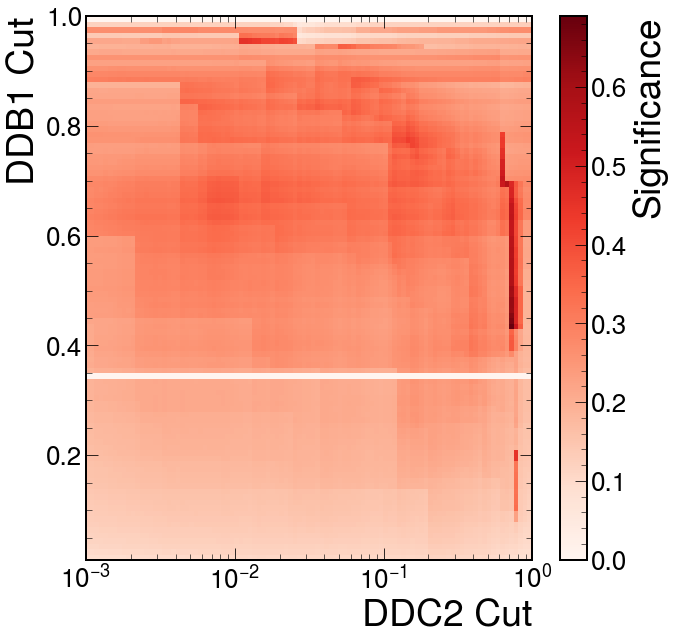

In [9]:
x = templates.axis('ddc2').edges()[1:]
y = templates.axis('ddb1').edges()[1:]

fig, ax = plt.subplots()

ax.set_xscale("log")
pos = ax.pcolor(x,y, scan_wh[1:,1:],cmap = 'Reds')
ax.autoscale('tight')

cbar = plt.colorbar(pos,ax = ax)
cbar.set_label('Significance')

plt.ylabel('DDB1 Cut')
plt.xlabel('DDC2 Cut')

plt.show()

## Check event yeilds

In [16]:
def event_yield(picklename, j2pt_thres = 200):
    
    templates = pickle.load(open(picklename,'rb'))\
            .integrate('msd1',slice(117.,131.))\
            .integrate('j2pt', slice(j2pt_thres,1200))\
            .integrate('region','signal')\
            .sum(*['ddb1', 'ddc2'])
    
    cols = ['Count']
    df = pd.DataFrame(index = mc, columns = cols)
    
    #loop over the processes and ddc2 scores and calcualte the events
    for process in mc:
        
        df.loc[process, 'Count'] = templates.integrate('process', process).values()[()]


    return df

In [21]:
event_yield(picklename, j2pt_thres = 400)

,Count
QCD,12991.009946352777
ttbar,500.988137123425
ttH,1.0124110819722152
singlet,48.32824371679298
Wjets,423.5077365722211
Zjets,184.59277325064204
VV,6.861783075216906
EWKZ,4.459263033781515
EWKW,19.77446557141104
ggF,2.8974055534094365


## ddc2 cutflow

In [29]:
def event_in_process_larger(picklename, step = 10):
    
    templates = pickle.load(open(picklename,'rb'))\
                  .integrate('msd1',slice(117.,131.))\
                  .integrate('ddb1', slice(0.87,1))\
                  .integrate('region','signal')\
                  .integrate('j2pt', slice(200,1200))\
    
    #New label for columns
    cols = [">={}".format(x) for x in templates.axis('ddc2').edges()][::step]
    edge_vals = templates.axis('ddc2').edges()[::step] #Coresponding edge value to use later

    df = pd.DataFrame(index = mc, columns = cols)
    
    #loop over the processes and ddc2 scores and calcualte the events
    for process in mc:
        for thres in edge_vals:
            df.loc[process, ">={}".format(thres)] = templates.integrate('process', process).integrate('ddc2', slice(thres,1)).values()[()]
    
    return df

larger_table = event_in_process_larger(picklename, step = 1)

In [30]:
larger_table

,>=0.0,>=0.001,>=0.0010722672220103231,>=0.0011497569953977356,>=0.0012328467394420659,>=0.0013219411484660286,>=0.0014174741629268048,>=0.0015199110829529332,>=0.0016297508346206436,>=0.001747528400007683,...,>=0.5336699231206312,>=0.572236765935022,>=0.6135907273413176,>=0.6579332246575682,>=0.7054802310718645,>=0.7564633275546291,>=0.8111308307896873,>=0.8697490026177834,>=0.9326033468832199,>=1.0
QCD,3.349374,3.349374,3.349374,3.349374,3.349374,3.349374,3.349374,3.349374,3.349374,3.349374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ttbar,0.302173,0.302173,0.302173,0.302173,0.302173,0.302173,0.302173,0.302173,0.302173,0.302173,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ttH,0.064685,0.062022,0.06078,0.059442,0.059442,0.059442,0.059442,0.059442,0.059442,0.059442,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
singlet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wjets,0.102253,0.102253,0.102253,0.102253,0.102253,0.102253,0.102253,0.102253,0.102253,0.102253,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zjets,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VV,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EWKZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EWKW,0.11612,0.11612,0.11612,0.11612,0.11612,0.11612,0.11612,0.11612,0.11612,0.11612,...,0.11612,0.11612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ggF,0.371158,0.325175,0.325175,0.284789,0.284789,0.284789,0.263374,0.263374,0.243019,0.243019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
larger_table.to_csv('csv_outfiles/ddc2_table_larger.csv')

In [34]:
def event_in_process_smaller(picklename, step = 10):
    
    templates = pickle.load(open(picklename,'rb'))\
                  .integrate('msd1',slice(117.,131.))\
                  .integrate('ddb1', slice(0.87,1))\
                  .integrate('region','signal')\
                  .integrate('j2pt', slice(200,1200))\
    
    #New label for columns
    cols = ["<{}".format(x) for x in templates.axis('ddc2').edges()][::step][1:]
    edge_vals = templates.axis('ddc2').edges()[::step][1:] #Coresponding edge value to use later

    df = pd.DataFrame(index = mc, columns = cols)
    
    #loop over the processes and ddc2 scores and calcualte the events
    for process in mc:
        for thres in edge_vals:
            df.loc[process, "<{}".format(thres)] = templates.integrate('process', process).integrate('ddc2', slice(0.,thres)).values()[()]
    
    return df

smaller_table = event_in_process_smaller(picklename, step = 1)

In [35]:
smaller_table

,<0.001,<0.0010722672220103231,<0.0011497569953977356,<0.0012328467394420659,<0.0013219411484660286,<0.0014174741629268048,<0.0015199110829529332,<0.0016297508346206436,<0.001747528400007683,<0.001873817422860383,...,<0.5336699231206312,<0.572236765935022,<0.6135907273413176,<0.6579332246575682,<0.7054802310718645,<0.7564633275546291,<0.8111308307896873,<0.8697490026177834,<0.9326033468832199,<1.0
QCD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.349374,3.349374,3.349374,3.349374,3.349374,3.349374,3.349374,3.349374,3.349374,3.349374
ttbar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.302173,0.302173,0.302173,0.302173,0.302173,0.302173,0.302173,0.302173,0.302173,0.302173
ttH,0.002662,0.003904,0.005243,0.005243,0.005243,0.005243,0.005243,0.005243,0.005243,0.005243,...,0.064685,0.064685,0.064685,0.064685,0.064685,0.064685,0.064685,0.064685,0.064685,0.064685
singlet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wjets,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.102253,0.102253,0.102253,0.102253,0.102253,0.102253,0.102253,0.102253,0.102253,0.102253
Zjets,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415
EWKZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EWKW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.11612,0.11612,0.11612,0.11612,0.11612,0.11612,0.11612,0.11612
ggF,0.045983,0.045983,0.086369,0.086369,0.086369,0.107784,0.107784,0.12814,0.12814,0.177822,...,0.371158,0.371158,0.371158,0.371158,0.371158,0.371158,0.371158,0.371158,0.371158,0.371158


In [36]:
smaller_table.to_csv('csv_outfiles/ddc2_table_smaller.csv')